#  Customer Segmentation & Retention Analysis  
###  E-Commerce Data Analysis Project  

**Author:** Binyam Abraha  
**Date:** Dec 28, 2024  

## ** Project Overview**  
In this project, we analyze an e-commerce dataset to uncover customer purchasing behaviors, segment customers, and provide insights for retention strategies.  

## ** Objectives**  
 Perform **Exploratory Data Analysis (EDA)** to identify key business trends.  
 Use **RFM (Recency, Frequency, Monetary) Analysis** to segment customers.  
 Provide actionable insights for improving customer retention.  

---


##  **Dataset Overview**  
Before we begin our analysis, let's load the dataset and inspect its structure.  
This dataset contains **customer transaction records**, including:  
- Invoice details (**InvoiceNo, Date, StockCode**).  
- Product descriptions and **quantities sold**.  
- **CustomerID and country of purchase**.  
- **Unit price per item** to calculate revenue.  

---

In [1]:
import pandas as pd

# Load the dataset
file_path = "/Users/binyamabraha/Desktop/Jupyter/Portfolio Projects/data.csv"  # Adjust if needed
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Display dataset info
df.info()

# Show first few rows
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


##  **Step 1: Data Cleaning & Preprocessing**  
Before analyzing customer behavior, we need to **clean and structure** the data:  
 **Handle missing values** (e.g., missing CustomerIDs).  
 **Remove duplicate transactions**.  
 **Separate refund transactions** instead of deleting them.  
 **Convert timestamps to datetime format** for accurate time-based analysis.  

---


In [2]:
# Check for missing values
missing_values = df.isnull().sum()

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()

# Check for negative quantities (potential refunds/cancellations)
negative_values = df[df["Quantity"] < 0]

# Print results
print(" Missing Values:\n", missing_values)
print("\n Duplicate Rows:", duplicate_rows)
print("\n Transactions with Negative Quantities (Refunds/Cancellations):")
display(negative_values.head())  # Show first few negative transactions


 Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

 Duplicate Rows: 5268

 Transactions with Negative Quantities (Refunds/Cancellations):


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [3]:
# Remove rows where CustomerID is missing
df_cleaned = df.dropna(subset=["CustomerID"])

# Verify missing values are handled
print("Missing values after cleaning:\n", df_cleaned.isnull().sum())


Missing values after cleaning:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [4]:
# Remove duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

# Verify duplicate removal
print(" Duplicate Rows after cleaning:", df_cleaned.duplicated().sum())


 Duplicate Rows after cleaning: 0


In [5]:
# Create a separate dataset for refunded/canceled transactions
df_refunds = df_cleaned[df_cleaned["Quantity"] < 0]

# Keep only positive transactions for primary analysis
df_cleaned = df_cleaned[df_cleaned["Quantity"] > 0]

# Verify
print(" Refund Transactions:", df_refunds.shape[0])
print(" Positive Transactions after separating refunds:", df_cleaned.shape[0])


 Refund Transactions: 8872
 Positive Transactions after separating refunds: 392732


In [6]:
# Convert InvoiceDate to datetime format
df_cleaned["InvoiceDate"] = pd.to_datetime(df_cleaned["InvoiceDate"])

# Verify
print("\n Data Types:\n", df_cleaned.dtypes)



 Data Types:
 InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


#  **Step 2: Exploratory Data Analysis (EDA)**  
To understand the dataset, we explore:  
 **Total sales, unique customers, and key business metrics**.  
 **Top-selling products and revenue-generating countries**.  
 **Sales trends over time to identify seasonality and growth patterns**.  

---


In [7]:
import numpy as np

# Total number of unique customers
unique_customers = df_cleaned["CustomerID"].nunique()

# Total revenue
df_cleaned["TotalPrice"] = df_cleaned["Quantity"] * df_cleaned["UnitPrice"]
total_revenue = df_cleaned["TotalPrice"].sum()

# Total orders
total_orders = df_cleaned["InvoiceNo"].nunique()

# Average order value
avg_order_value = total_revenue / total_orders

# Print results
print(f" Unique Customers: {unique_customers}")
print(f" Total Revenue: ${total_revenue:,.2f}")
print(f" Total Orders: {total_orders}")
print(f" Average Order Value: ${avg_order_value:.2f}")


 Unique Customers: 4339
 Total Revenue: $8,887,208.89
 Total Orders: 18536
 Average Order Value: $479.46


##  **Top 10 Best-Selling Products**  
This visualization shows the **most purchased products** based on total quantity sold. Identifying top sellers helps businesses optimize inventory and promotions.  


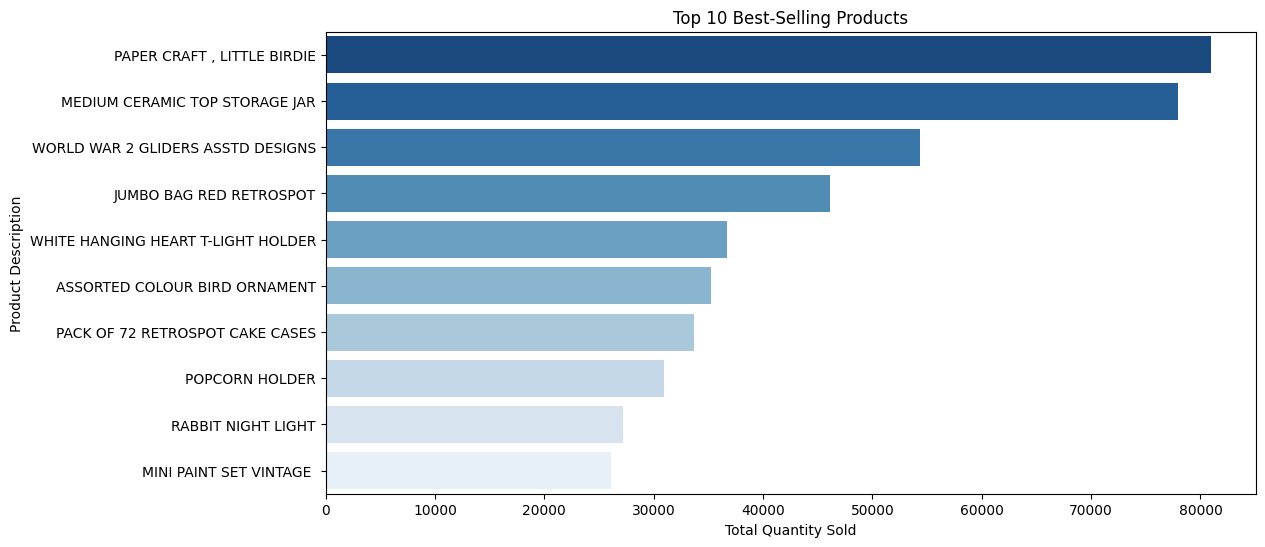

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate total quantity sold per product
top_products = df_cleaned.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)

# Plot Top 10 Best-Selling Products 
plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, hue=top_products.index, dodge=False, legend=False, palette="Blues_r")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.title("Top 10 Best-Selling Products")
plt.show()



##  **Top 10 Revenue-Generating Countries**  
Which countries contribute the most revenue? This analysis helps businesses target high-value markets.  


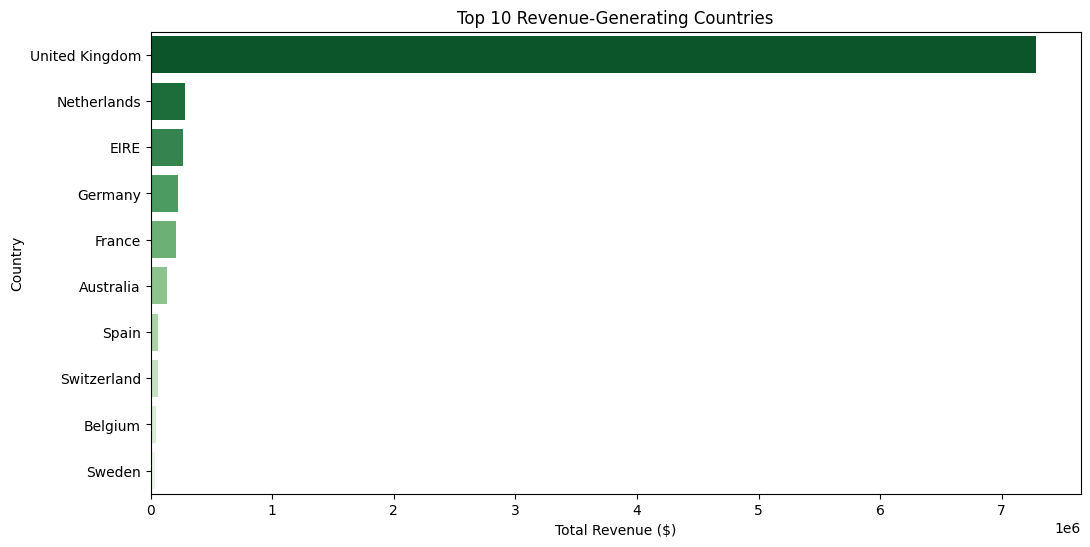

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate revenue per country
top_countries = df_cleaned.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False).head(10)

# Plot Top 10 Revenue-Generating Countries 
plt.figure(figsize=(12,6))
sns.barplot(x=top_countries.values, y=top_countries.index, hue=top_countries.index, dodge=False, legend=False, palette="Greens_r")
plt.xlabel("Total Revenue ($)")
plt.ylabel("Country")
plt.title("Top 10 Revenue-Generating Countries")
plt.show()



##  **Monthly Sales Trend Analysis**  
How do sales fluctuate over time? This analysis uncovers seasonality, peak sales months, and trends.  


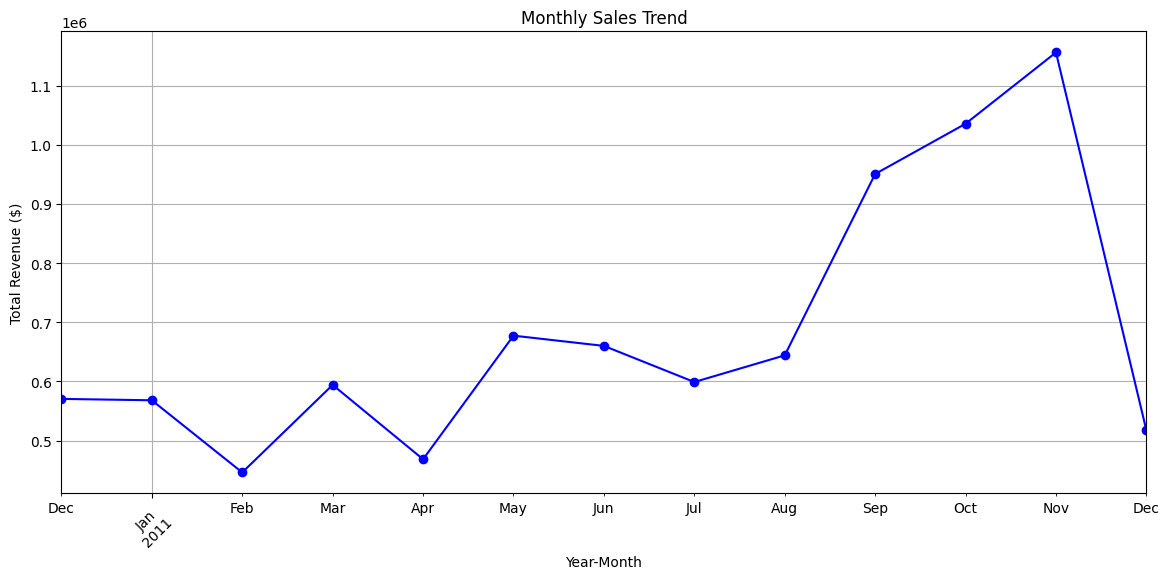

In [14]:
import matplotlib.pyplot as plt

# Extract year and month for time-series analysis
df_cleaned["YearMonth"] = df_cleaned["InvoiceDate"].dt.to_period("M")

# Aggregate total revenue per month
monthly_sales = df_cleaned.groupby("YearMonth")["TotalPrice"].sum()

# Plot Monthly Sales Trend
plt.figure(figsize=(14,6))
monthly_sales.plot(marker="o", color="b", linestyle="-")
plt.xlabel("Year-Month")
plt.ylabel("Total Revenue ($)")
plt.title("Monthly Sales Trend")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


#  **Step 3: Customer Segmentation (RFM Analysis)**  
To understand customer purchasing behavior, we perform **RFM Analysis**:  
- **Recency (R)** → How recently has a customer made a purchase?  
- **Frequency (F)** → How often do they purchase?  
- **Monetary Value (M)** → How much do they spend?  

This helps us group customers into **high-value, regular, and at-risk** segments for targeted marketing.  

---


In [15]:
import datetime as dt

# Define the latest date in the dataset (we use max InvoiceDate as the reference point)
latest_date = df_cleaned["InvoiceDate"].max()

# Calculate RFM metrics
rfm = df_cleaned.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (latest_date - x.max()).days,  # Recency (days since last purchase)
    "InvoiceNo": "nunique",  # Frequency (number of unique orders)
    "TotalPrice": "sum"  # Monetary (total spending)
})

# Rename columns
rfm.columns = ["Recency", "Frequency", "Monetary"]

# Display first few rows
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


In [16]:
# Remove customers with Monetary Value = 0 (possible data issues)
rfm = rfm[rfm["Monetary"] > 0]

# Check the distribution of RFM metrics
rfm.describe()


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,91.536422,4.272706,2048.688081
std,100.014169,7.706221,8985.230220
min,0.000000,1.000000,3.750000
25%,17.000000,1.000000,306.482500
50%,50.000000,2.000000,668.570000
75%,141.000000,5.000000,1660.597500
max,373.000000,210.000000,280206.020000


##  Understanding RFM Scores  

Each customer is assigned an **RFM score** based on their purchasing behavior:  
- **Recency (R)** → How recently has the customer made a purchase?  
- **Frequency (F)** → How often do they purchase?  
- **Monetary (M)** → How much do they spend?  

Each metric is **scored from 1 to 5**:  
- **5 = Best (Most recent, frequent, and high-spending customers)**  
- **1 = Worst (Inactive, rare buyers, low spending)**  

### ** How RFM Scores are Used in Segmentation**
- **"555" = Best Customers (VIPs)**
- **"111" = Lost Customers (High churn risk)**
- **"515" = Big Spenders but Infrequent Buyers**
- **"344" = Loyal Customers**

Now, let's calculate **RFM Scores** for all customers! 


In [19]:
# Create RFM scores (1 to 5)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])  # Recent purchases get high scores
rfm["F_Score"] = pd.cut(rfm["Frequency"], bins=5, labels=[1, 2, 3, 4, 5], include_lowest=True)  # Fix binning issue
rfm["M_Score"] = pd.cut(rfm["Monetary"], bins=5, labels=[1, 2, 3, 4, 5], include_lowest=True)  # Fix binning issue

# Create final RFM Score by combining R, F, and M scores as strings
rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)

# Display first few rows
rfm.head()



,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346.0,325,1,77183.60,1,1,2,112
12347.0,1,7,4310.00,5,1,1,511
12348.0,74,4,1797.24,2,1,1,211
12349.0,18,1,1757.55,4,1,1,411
12350.0,309,1,334.40,1,1,1,111


In [21]:
# Define RFM segment mapping with broader criteria
def assign_segment(rfm_score):
    if rfm_score in ["555", "554", "545", "544", "543"]:
        return "Best Customers"
    elif rfm_score in ["535", "533", "453", "445", "444"]:
        return "Loyal Customers"
    elif rfm_score in ["435", "343", "334", "323"]:
        return "Potential Loyalists"
    elif rfm_score in ["322", "233", "223", "222", "211"]:
        return "At Risk"
    elif rfm_score in ["111", "112", "121", "122"]:
        return "Lost Customers"
    else:
        return "Others"

# Apply the new segmentation function
rfm["Segment"] = rfm["RFM_Score"].apply(assign_segment)

# Display new segment counts
rfm["Segment"].value_counts()


Segment
Others            2629
Lost Customers     865
At Risk            844
Name: count, dtype: int64

##  Customer Segmentation Based on RFM Scores  

This chart shows how customers are distributed across segments:  
- **"Others" dominate the customer count (~2,629 customers).**  
- **"At Risk" (844 customers)** are critical for retention strategies.  
- **"Lost Customers" (865 customers)** may require win-back campaigns.  


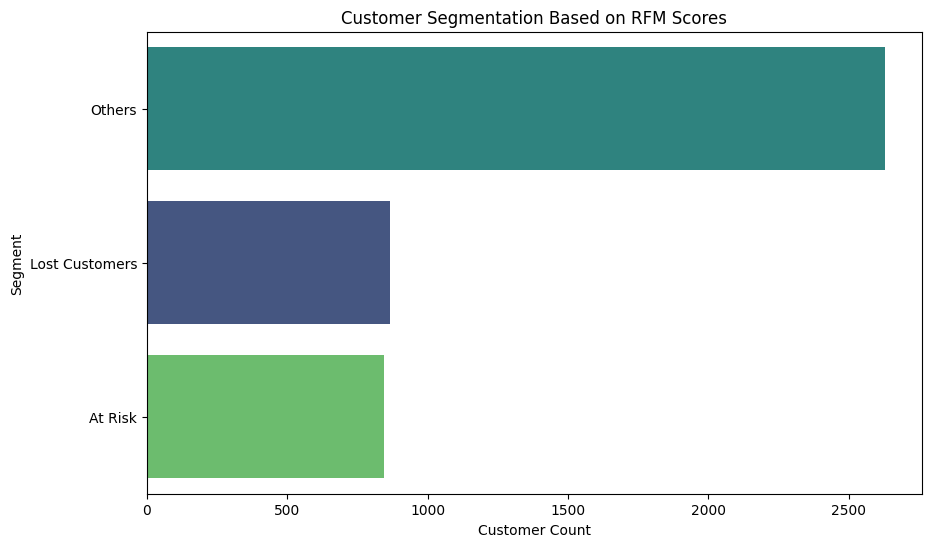

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot customer segments 
plt.figure(figsize=(10,6))
sns.countplot(y=rfm["Segment"], order=rfm["Segment"].value_counts().index, hue=rfm["Segment"], dodge=False, legend=False, palette="viridis")
plt.xlabel("Customer Count")
plt.ylabel("Segment")
plt.title("Customer Segmentation Based on RFM Scores")
plt.show()



##  Revenue Contribution by Customer Segment  

This pie chart highlights revenue contributions:  
- **"Others" contribute 84.3% of revenue, driven by their size.**  
- **"At Risk" contributes 9.4%, underscoring their importance.**  


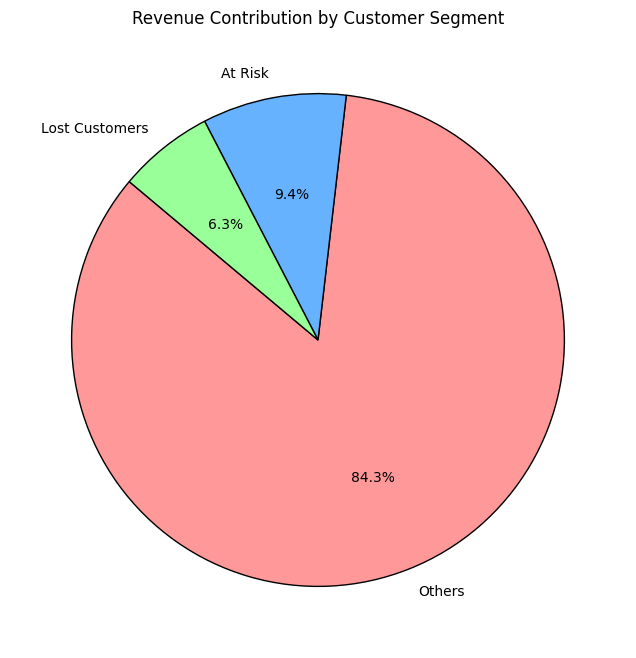

In [28]:
# Calculate revenue share per segment
segment_revenue_share = rfm.groupby("Segment")["Monetary"].sum().sort_values(ascending=False)
revenue_percentages = (segment_revenue_share / segment_revenue_share.sum()) * 100

# Plot pie chart
plt.figure(figsize=(8,8))
colors = ["#FF9999", "#66B2FF", "#99FF99"]  # Custom color palette
plt.pie(
    revenue_percentages, 
    labels=segment_revenue_share.index, 
    autopct="%1.1f%%", 
    startangle=140, 
    colors=colors, 
    wedgeprops={"edgecolor": "black"}
)
plt.title("Revenue Contribution by Customer Segment")
plt.show()



##  Customer Distribution: Recency vs. Frequency  

This scatterplot reveals purchasing patterns:  
- **High frequency, recent purchases = loyal customers.**  
- **Low frequency, distant purchases = "Lost Customers."**  
- Focus on customers with **moderate recency and frequency** to boost retention.  


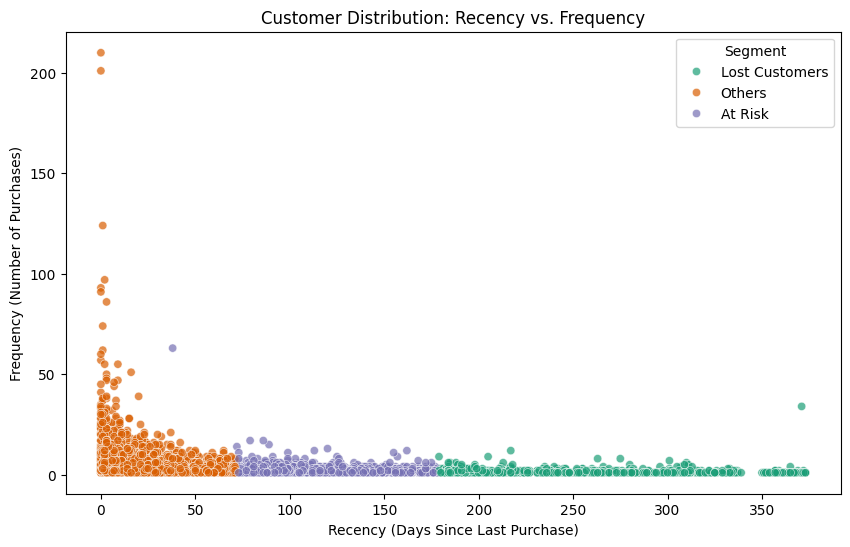

In [25]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Recency", y="Frequency", hue="Segment", data=rfm, palette="Dark2", alpha=0.7)

plt.xlabel("Recency (Days Since Last Purchase)")
plt.ylabel("Frequency (Number of Purchases)")
plt.title("Customer Distribution: Recency vs. Frequency")
plt.legend(title="Segment", bbox_to_anchor=(1,1))  # Move legend outside for clarity
plt.show()


#  Business Recommendations  

##  Retention Strategies for "At Risk" Customers  
- Launch personalized re-engagement campaigns (e.g., special discounts).  
- Introduce loyalty rewards to incentivize repeat purchases.  
- Follow up with surveys to understand reduced engagement.  

##  Reactivation Strategies for "Lost Customers"  
- Run win-back campaigns offering exclusive promotions.  
- Use email marketing with personalized messaging.  
- Highlight new arrivals or trending products to rekindle interest.  

##  Enhance Loyalty for "Others"  
- Promote exclusive membership programs (e.g., free shipping or VIP perks).  
- Use AI-driven recommendations to encourage upselling and cross-selling.  
- Offer targeted discounts for frequent purchasing.  

##  Optimize Inventory & Marketing  
- Focus inventory on products popular among "At Risk" and "Others."  
- Tailor marketing efforts to maximize ROI for "At Risk" customers.  

##  Monitor & Reassess Regularly  
- Perform RFM segmentation quarterly to track segment migration.  
- Use dashboards to monitor KPIs (e.g., recency trends, churn rates).  
- Continuously refine campaigns based on new insights.  
